In [1]:
## Imports

In [1]:
import xarray as xr

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import xgcm
from typing import Annotated
from xhistogram.xarray import histogram

In [5]:
print(xr.__version__)

2025.4.0


In [2]:
## Open the data

In [3]:
# data in persistent bucket
target_url ='gs://leap-persistent/cspencerjones/hero-calc/compute/llc4320/masked_hist_renorm_48hr.zarr'

In [4]:
hist_ds = xr.open_dataset(target_url, engine="zarr", chunks={})

RuntimeError: please await ``.set_session`` before anything else

In [5]:
from xarray.indexes import PandasIndex

# have to add the index ourselves manually for some reason
hist_ds = hist_ds.set_xindex('region_num', PandasIndex)

/tmp/ipykernel_80/2510200718.py:34: RuntimeWarning: invalid value encountered in divide
  u_diff_x = (u[..., 1:] - u[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_80/2510200718.py:35: RuntimeWarning: invalid value encountered in divide
  v_diff_x = (v[..., 1:] - v[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_80/2510200718.py:36: RuntimeWarning: invalid value encountered in divide
  u_diff_y = (u[..., 1:, :] - u[..., :-1, :]) / dyc[..., 1:, :]
/tmp/ipykernel_80/2510200718.py:37: RuntimeWarning: invalid value encountered in divide
  v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) / dyc[..., 1:, :]


In [6]:
## Expectation values

In [7]:
def marginalize(pdf: xr.DataArray, dims: str | list = None) -> xr.DataArray:
    """
    Integrate out one or more dimensions of the PDF to remove dependence on that quantity,
    whilst still preserving the total integrated probability.
    """
       
    all_bin_dims = ['vort_bin', 'strain_bin', 'div_bin']
    
    if isinstance(dims, str):
        dims = [dims]
    
    if dims is None:
        dims=all_bin_dims
    
    if any(d not in all_bin_dims for d in dims):
        raise ValueError("Can't take marginal PDF over a dimension which is not a variable of the original PDF")
    
    marginal_pdf = pdf

    # TODO these might be more accurate if we used xarray's integrate function
    if 'vort_bin' in dims:
        vort_bin_width = pdf['vort_bin'].diff('vort_bin')[0]
        marginal_pdf = marginal_pdf.sum(dim='vort_bin') * vort_bin_width
        
    if 'strain_bin' in dims:
        strain_bin_width = pdf['strain_bin'].diff('strain_bin')[0]
        marginal_pdf = marginal_pdf.sum(dim='strain_bin') * strain_bin_width
        
    if 'div_bin' in dims:
        div_bin_width = pdf['div_bin'].diff('div_bin')[0]
        marginal_pdf = marginal_pdf.sum(dim='div_bin') * div_bin_width
        
    return marginal_pdf

def expectation(pdf: xr.DataArray, x: xr.DataArray, dims: str | list = None) -> xr.DataArray:
    """
    Take the expectation value of x over the given Probability Density Function.
    """
    
    return marginalize(pdf * x, dims=dims)

In [8]:
@xr.register_dataarray_accessor("pdf")
class DataArrayPDFAccessor:
    def __init__(self, da: xr.DataArray):
        self._da = da
        
    def marginalize(self, dims: str | list = None) -> xr.DataArray:
        return marginalize(self._da, dims=dims)
    
    def expectation(self, x, dims: str | list = None) -> xr.DataArray:
        return expectation(self._da, x, dims=dims)

In [9]:
## Look at summer hemisphere

In [10]:
lats = hist_ds['vertices_latitude'].isel(vertices=0).compute()
lats.where((lats>-55)&(lats<-30),drop=True)['region_num']

<xarray.DataArray 'region_num' (region: 88)> Size: 704B
array([ 65,  66,  67,  73,  74,  75,  81,  82,  83,  89,  90,  91,  97,  98,
        99, 105, 106, 113, 114, 115, 121, 122, 123, 257, 258, 259, 265, 266,
       267, 273, 274, 275, 281, 282, 283, 289, 290, 291, 297, 298, 305, 306,
       313, 314, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564,
       565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 744, 745, 746,
       747, 748, 750, 751, 752, 753, 754, 755, 756, 758, 759, 760, 761, 762,
       763, 764, 766, 767])
Coordinates:
    face                (region) int64 704B 1 1 1 1 1 1 1 ... 11 11 11 11 11 11
    i_region_coarse     (region) int64 704B 0 0 0 1 1 1 2 2 ... 6 7 7 7 7 7 7 7
    j_region_coarse     (region) int64 704B 1 2 3 1 2 3 1 2 ... 7 0 1 2 3 4 6 7
  * region_num          (region) int64 704B 65 66 67 73 74 ... 763 764 766 767
    vertices_latitude   (region) float32 352B -50.68 -43.52 ... -50.69 -50.69
    vertices_longitude  (region) float32 352B -37.99 -37.99 ... -60.49 -49.24
Dimensions without coordinates: region

/tmp/ipykernel_80/2510200718.py:34: RuntimeWarning: invalid value encountered in divide
  u_diff_x = (u[..., 1:] - u[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_80/2510200718.py:35: RuntimeWarning: invalid value encountered in divide
  v_diff_x = (v[..., 1:] - v[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_80/2510200718.py:36: RuntimeWarning: invalid value encountered in divide
  u_diff_y = (u[..., 1:, :] - u[..., :-1, :]) / dyc[..., 1:, :]
/tmp/ipykernel_80/2510200718.py:37: RuntimeWarning: invalid value encountered in divide
  v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) / dyc[..., 1:, :]
/tmp/ipykernel_80/2510200718.py:34: RuntimeWarning: invalid value encountered in divide
  u_diff_x = (u[..., 1:] - u[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_80/2510200718.py:35: RuntimeWarning: invalid value encountered in divide
  v_diff_x = (v[..., 1:] - v[..., :-1]) / dxc[..., 1:]
/tmp/ipykernel_80/2510200718.py:36: RuntimeWarning: invalid value encountered in divide
  u_diff_y = (u[..., 1:, :] - u[...,

In [11]:
hist_ds.sel(region_num = 65)['vertices_latitude'].values

array([-50.677643, -50.677643, -43.533653, -43.533653], dtype=float32)

In [12]:
hist_ds.sel(region_num = 65)['vertices_longitude'].values

array([-37.989582, -26.760416, -26.760416, -37.989582], dtype=float32)

In [13]:
#Jan/Feb/Mar
JFM_65 = hist_ds.sel(region_num = 65)['histogram_vort_strain_div'].isel(time=11)#slice(11,20)).mean('time')

In [14]:
hist_ds.sel(region_num = 65)['histogram_vort_strain_div'].isel(time=slice(11,20)).time

<xarray.DataArray 'time' (time: 9)> Size: 72B
array(['2012-01-05T00:00:00.000000000', '2012-01-15T00:00:00.000000000',
       '2012-01-25T00:00:00.000000000', '2012-02-04T00:00:00.000000000',
       '2012-02-14T00:00:00.000000000', '2012-02-24T00:00:00.000000000',
       '2012-03-05T00:00:00.000000000', '2012-03-15T00:00:00.000000000',
       '2012-03-25T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
    face             int64 8B dask.array<chunksize=(), meta=np.ndarray>
    i_region_coarse  int64 8B dask.array<chunksize=(), meta=np.ndarray>
    j_region_coarse  int64 8B dask.array<chunksize=(), meta=np.ndarray>
    region_num       int64 8B 65
  * time             (time) datetime64[ns] 72B 2012-01-05 ... 2012-03-25

In [15]:
JFM_65_DivPdf = (JFM_65*JFM_65.div_bin).mean('div_bin').load()
#JFM_65_DivPdf2 = JFM_65_DivPdf.where(JFM_65_DivPdf>2*10**-3).load()

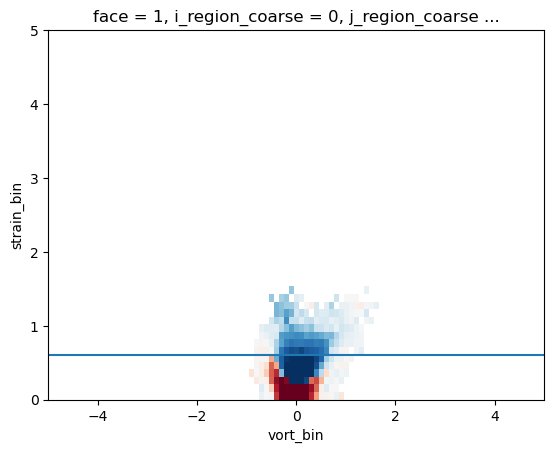

In [16]:
JFM_65_DivPdf.plot(x='vort_bin', vmax=0.01, norm=mpl.colors.SymLogNorm(1e-3),add_colorbar=False)
plt.axhline(0.6)

In [2]:
def open_llc4320_velocity_data(chunks='auto', time_range=None):
    
    ds_SSU = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/ssu", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        inline_array=True,
        consolidated=True, 
    )
    
    ds_SSV = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/ssv", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        inline_array=True,
        consolidated=True, 
    )
    
    # Open grid data
    ds_grid = xr.open_dataset(
        "gs://pangeo-ecco-llc4320/grid", 
        engine="zarr", 
        storage_options={'requester_pays': True}, 
        chunks=chunks, 
        inline_array=True,
        consolidated=True, 
    )
    
    coords_to_keep = ['XC', 'YC', 'dxC', 'dyC', 'dxG', 'dyG', 'rAz', 'rA', 'Depth']
    ds_grid = ds_grid.reset_coords()[coords_to_keep]
    
    ds = xr.merge([ds_SSU, ds_SSV, ds_grid])
    
    if time_range is not None:
        ds = ds.isel(time=time_range)
        
    ds = ds.chunk(chunks)
    
    return ds, ds_grid
    

In [3]:
ds, ds_grid = open_llc4320_velocity_data(chunks={})

In [4]:
grid = xgcm.Grid(ds_grid, periodic=False)

In [5]:



@xgcm.as_grid_ufunc(
    boundary_width={"X": (1, 0), "Y": (1, 0)},
    boundary="fill",
    fill_value=np.nan,
    dask="parallelized",    
)
def vort(
    u:   Annotated[np.ndarray, "(Y:center,X:left)"],
    dxc: Annotated[np.ndarray, "(Y:center,X:left)"],
    v:   Annotated[np.ndarray, "(Y:left,X:center)"],
    dyc: Annotated[np.ndarray, "(Y:left,X:center)"],
    raz: Annotated[np.ndarray, "(Y:left,X:left)"],
) ->     Annotated[np.ndarray, "(Y:left,X:left)"]:
    """Dimensional vorticity"""
    
    u_trans = u * dxc
    v_trans = v * dyc
    v_diff_x = v_trans[..., 1:, 1:] - v_trans[..., 1:, :-1]
    u_diff_y = u_trans[..., 1:, 1:] - u_trans[..., :-1, 1:]
    return (v_diff_x - u_diff_y) / raz[..., 1:, 1:]

@xgcm.as_grid_ufunc(
    boundary_width={"X": (1, 0), "Y": (1, 0)},
    boundary="fill",
    fill_value=np.nan,
    dask="parallelized",    
)
def strain(
    u:   Annotated[np.ndarray, "(Y:center,X:left)"],
    dxc: Annotated[np.ndarray, "(Y:center,X:left)"],
    v:   Annotated[np.ndarray, "(Y:left,X:center)"],
    dyc: Annotated[np.ndarray, "(Y:left,X:center)"],
) ->     Annotated[np.ndarray, "(Y:left,X:left)"]:
    u_diff_x = (u[..., 1:] - u[..., :-1]) / dxc[..., 1:]
    v_diff_x = (v[..., 1:] - v[..., :-1]) / dxc[..., 1:]
    u_diff_y = (u[..., 1:, :] - u[..., :-1, :]) / dyc[..., 1:, :]
    v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) / dyc[..., 1:, :]
    
    u_diff_x_trimmed = u_diff_x[..., 1:, :]
    v_diff_x_trimmed = v_diff_x[..., 1:, :]
    u_diff_y_trimmed = u_diff_y[..., 1:]
    v_diff_y_trimmed = v_diff_y[..., 1:]
    
    strain_normal = u_diff_x_trimmed - v_diff_y_trimmed
    strain_shear = v_diff_x_trimmed + u_diff_y_trimmed
    
    # TODO: interpolate the shear strain onto the positions of the normal strain
    # For now, we just pretend they are at the same grid point
    strain_mag = np.sqrt(strain_normal ** 2 +  strain_shear ** 2)
    
    return strain_mag

@xgcm.as_grid_ufunc(
    boundary_width={"X": (1, 0), "Y": (1, 0)},
    boundary="fill",
    fill_value=np.nan,
    dask="parallelized",
)
def divergence(
    u:   Annotated[np.ndarray, "(Y:center,X:left)"],
    dxg: Annotated[np.ndarray, "(Y:left,X:center)"],
    v:   Annotated[np.ndarray, "(Y:left,X:center)"],
    dyg: Annotated[np.ndarray, "(Y:center,X:left)"],
    ra:  Annotated[np.ndarray, "(Y:center,X:center)"],
) ->     Annotated[np.ndarray, "(Y:center,X:center)"]:
    
    u_diff_x = (u[..., 1:] - u[..., :-1]) * dxg[..., 1:]
    v_diff_y = (v[..., 1:, :] - v[..., :-1, :]) * dyg[..., 1:, :]
    
    u_diff_x_trimmed = u_diff_x[..., 1:, :]
    v_diff_y_trimmed = v_diff_y[..., 1:]
    
    divergence = (u_diff_x_trimmed + v_diff_y_trimmed) / ra[..., 1:, 1:]
    
    return divergence

In [6]:

def vort_strain_div_bins(n_strain_bins=100, n_vort_bins=200, n_div_bins=200, vort_max=5, strain_max=5, div_max=5):
    vort_bins = np.linspace(-vort_max, vort_max, n_vort_bins)
    strain_bins = np.linspace(0.0, strain_max, n_strain_bins)
    div_bins = np.linspace(-div_max, div_max, n_div_bins)
    return vort_bins, strain_bins, div_bins

In [22]:
vort_bins, strain_bins, div_bins = vort_strain_div_bins(n_strain_bins=50, n_vort_bins=100, n_div_bins=100)
a = np.diff(vort_bins)[0]*np.diff(strain_bins)[0]*np.diff(div_bins)[0]

In [23]:
ζ = vort(grid, ds.U, ds.dxC, ds.V, ds.dyC, ds.rAz, axis= 5 * [("Y", "X")])
σ = strain(grid, ds.U, ds.dxC, ds.V, ds.dyC, axis=4 * [("Y", "X")])
D = divergence(grid, ds.U, ds.dxG, ds.V, ds.dyG, ds.rA, axis= 5 * [("Y", "X")])

/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/srv/conda/envs/notebook/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in orde

In [24]:
#σ_piece = σ.isel(time=2736).sel(face=1).isel(i_g=slice(0,550)).isel(j_g=slice(550,1100)).rename({"i_g": "i", "j_g": "j"})/10**-4
#ζ_piece = ζ.isel(time=2736).sel(face=1).isel(i_g=slice(0,550)).isel(j_g=slice(550,1100)).rename({"i_g": "i", "j_g": "j"})/(-10**-4)
#D_piece = D.isel(time=2736).sel(face=1).isel(i=slice(0,550)).isel(j=slice(550,1100))/10**-4

#σ_piece = σ.isel(time=2736).sel(face=1).isel(i_g=slice(0,550)).isel(j_g=slice(1100,1650)).rename({"i_g": "i", "j_g": "j"})/10**-4
#ζ_piece = ζ.isel(time=2736).sel(face=1).isel(i_g=slice(0,550)).isel(j_g=slice(1100,1650)).rename({"i_g": "i", "j_g": "j"})/(-10**-4)
#D_piece = D.isel(time=2736).sel(face=1).isel(i=slice(0,550)).isel(j=slice(1100,1650))/10**-4

σ_piece = σ.isel(time=4500).sel(face=1).isel(i_g=slice(1100,1650)).isel(j_g=slice(2200,2850)).rename({"i_g": "i", "j_g": "j"})/10**-4
ζ_piece = ζ.isel(time=4500).sel(face=1).isel(i_g=slice(1100,1650)).isel(j_g=slice(2200,2850)).rename({"i_g": "i", "j_g": "j"})/(-10**-4)
D_piece = D.isel(time=4500).sel(face=1).isel(i=slice(1100,1650)).isel(j=slice(2200,2850))/10**-4

In [25]:
h = histogram(
    ζ_piece.rename('vort'),
    σ_piece.rename('strain'),
    D_piece.rename('div'),
    bins=[vort_bins, strain_bins, div_bins],
    block_size=None,  # avoids a divide-by-zero bug in xhistogram's code for automatically determining block_size
    density=False,  # setting this to true leads to an error right now
    keep_coords=True,
)
h = h/a/550/550

In [26]:
ds.time[4500]

<xarray.DataArray 'time' ()> Size: 8B
array('2012-03-18T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 8B 2012-03-18T12:00:00
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

In [27]:
h_vort_strain = (h.pdf.marginalize('div_bin')/97).load()
h_DivPdf = (h*h.div_bin).mean('div_bin').load()
lat = ds.sel(face=1).YC.mean('i')
lon = ds.sel(face=1).XC.mean('j')

lon_piece = ds.sel(face=1).isel(i=slice(1100,1650)).isel(j=slice(2200,2850)).XC.mean('j')
lat_piece = ds.sel(face=1).isel(i=slice(1100,1650)).isel(j=slice(2200,2850)).YC.mean('i')

In [34]:
(lat_piece.isel(j=200)-lat_piece.isel(j=0)).values

array(3.4924335, dtype=float32)

<>:24: SyntaxWarning: invalid escape sequence '\z'
<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\z'
<>:25: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_80/1013487966.py:24: SyntaxWarning: invalid escape sequence '\z'
  plt.xlabel('$\zeta/f_{floor}$')
/tmp/ipykernel_80/1013487966.py:25: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sigma/f_{floor}$')
/tmp/ipykernel_80/1013487966.py:7: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  plt.contourf(lon_piece,lat_piece,ζ_piece.values, levels=np.arange(-1,1.05,0.01)*0.5,add_colorbar=False, cmap='bwr')


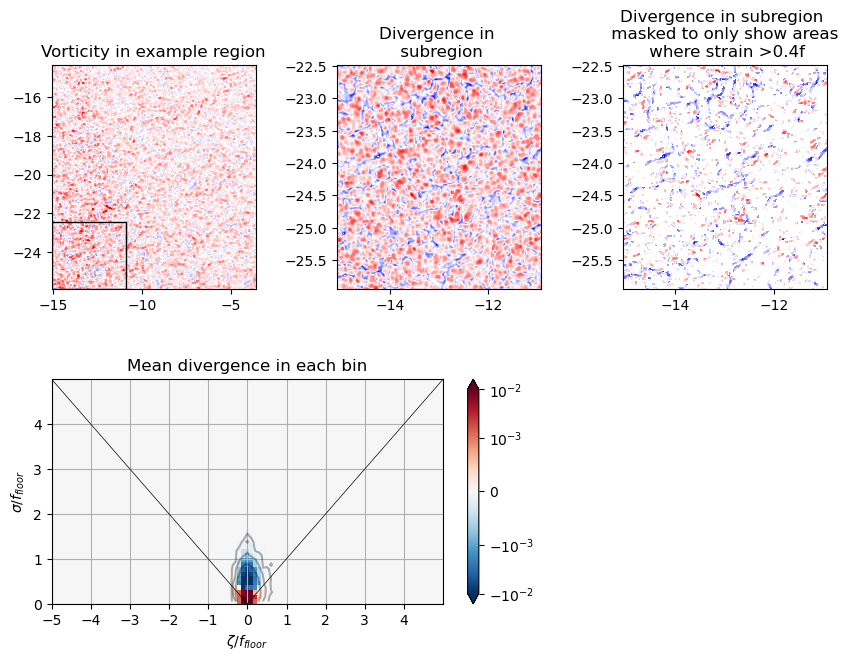

In [35]:
import matplotlib.patches as patches
fig3 = plt.figure(figsize=(10,7))
gs = fig3.add_gridspec(2, 3)


fig3.add_subplot(gs[0, 0])
plt.contourf(lon_piece,lat_piece,ζ_piece.values, levels=np.arange(-1,1.05,0.01)*0.5,add_colorbar=False, cmap='bwr')
#ζ_piece.plot(levels=np.arange(-1,1.05,0.01)*0.5)
plt.title('Vorticity in example region')
rect = patches.Rectangle((lon_piece.isel(i=0).values, lat_piece.isel(j=0).values), 4.17, 3.5, linewidth=1, edgecolor='k', facecolor='none')

# Add the patch to the Axes
plt.gca().add_patch(rect)



fig3.add_subplot(gs[1, 0:2])
h_DivPdf.plot(x='vort_bin', vmax=0.01, norm=mpl.colors.SymLogNorm(1e-3))
h_vort_strain.plot.contour(x='vort_bin',levels=[1e-3, 1e-4, 1e-5], colors='k', alpha=.3)
plt.title('Mean divergence in each bin')
plt.plot(np.linspace(0,5), np.linspace(0,5),color='k',linewidth=0.5)
plt.plot(np.linspace(-5,0), np.linspace(5,0),color='k',linewidth=0.5)

plt.xlabel('$\zeta/f_{floor}$')
plt.ylabel('$\sigma/f_{floor}$')
plt.grid()

x_ticks = np.arange(-5, 5)
y_ticks = np.arange(0, 5)

plt.gca().set_xticks(x_ticks)

plt.gca().set_yticks(y_ticks)

fig3.add_subplot(gs[0, 1])
plt.contourf(lon_piece.isel(i=slice(0,200)),lat_piece.isel(j=slice(0,200)),D_piece.isel(i=slice(0,200)).isel(j=slice(0,200)).values, levels=np.arange(-1,1.05,0.01), cmap='bwr')
plt.title('Divergence in \n subregion')

fig3.add_subplot(gs[0, 2])
plt.contourf(lon_piece.isel(i=slice(0,200)),lat_piece.isel(j=slice(0,200)),D_piece.where((σ_piece>0.4)).isel(i=slice(0,200)).isel(j=slice(0,200)).values, levels=np.arange(-1,1.05,0.01), cmap='bwr')
plt.title('Divergence in subregion \n masked to only show areas \n where strain >0.4f')

plt.subplots_adjust(hspace=0.4, wspace=0.4)

plt.gcf().savefig('region_loc.png')
plt.show()

In [ ]:
ds.sel(face=1).isel(i=slice(1100,1650)).isel(j=slice(2200,2850)).YC.min().values
#3.6+7.8

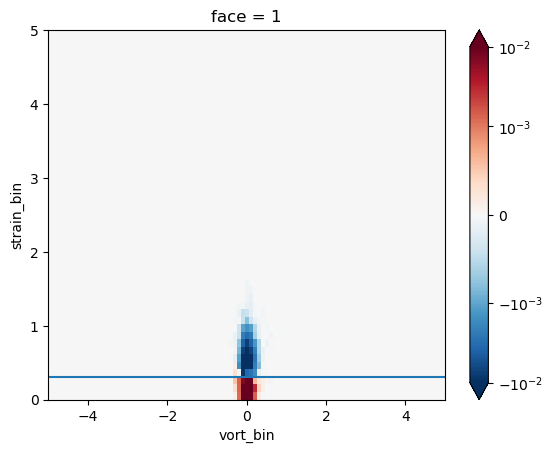

In [55]:
h_DivPdf.plot(x='vort_bin', vmax=0.01, norm=mpl.colors.SymLogNorm(1e-3))
plt.axhline(0.3)
#plt.axhline(1)
plt.gcf().savefig('jpdf_region.png')

In [43]:
h_DivPdf

<xarray.DataArray (vort_bin: 99, strain_bin: 49)> Size: 39kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * vort_bin    (vort_bin) float64 792B -4.949 -4.848 -4.747 ... 4.848 4.949
  * strain_bin  (strain_bin) float64 392B 0.05102 0.1531 0.2551 ... 4.847 4.949
    face        int64 8B 1

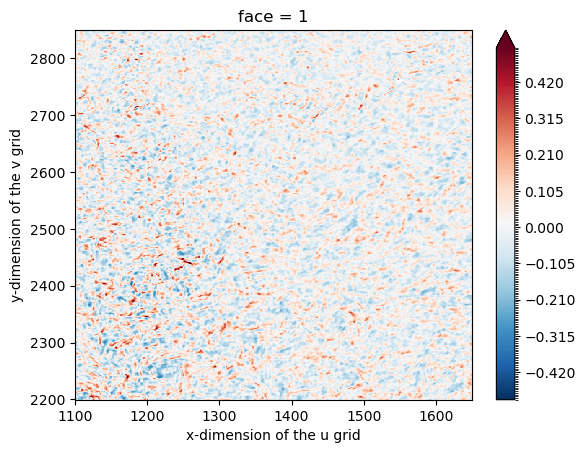

In [52]:
ζ_piece.plot(levels=np.arange(-1,1.05,0.01)*0.5)
plt.gcf().savefig('vort_region.png')

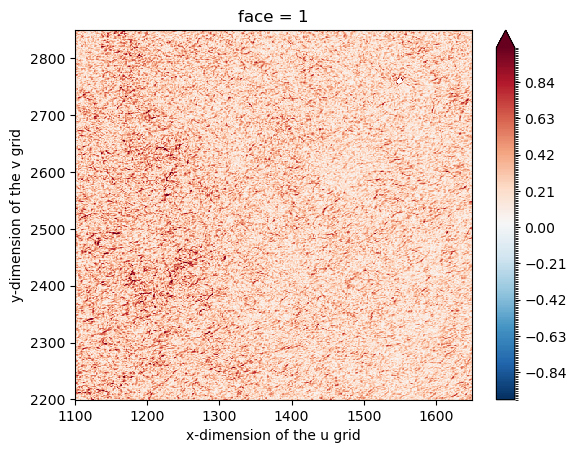

In [53]:
σ_piece.plot(levels=np.arange(-1,1.05,0.01))
plt.gcf().savefig('strain_region.png')

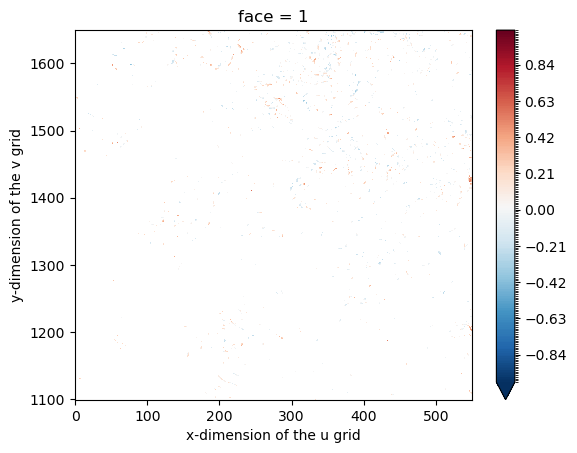

In [110]:
ζ_piece.where((σ_piece>0.5)&(σ_piece<1)).plot(levels=np.arange(-1,1.05,0.01))

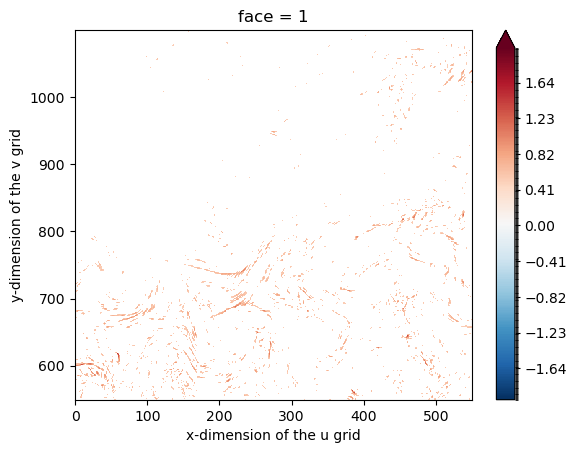

In [79]:
σ_piece.where((σ_piece>0.5)&(σ_piece<1).plot(levels=np.arange(-2,2.05,0.01))

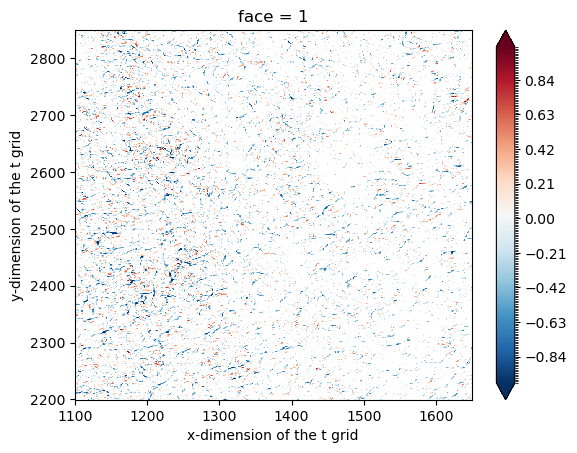

In [34]:
D_piece.where((σ_piece>0.4)).plot(levels=np.arange(-1,1.05,0.01))

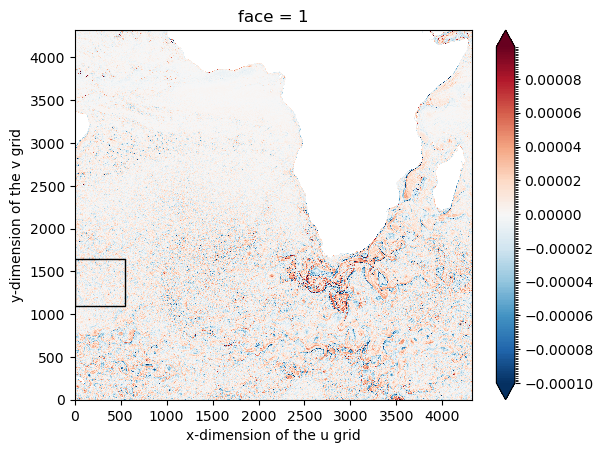

In [94]:
## Make gifs

In [48]:
σ_piece2 = σ.isel(time=slice(2736, 2786)).sel(face=1).isel(i_g=slice(0,550)).isel(j_g=slice(1100,1650)).rename({"i_g": "i", "j_g": "j"})/10**-4
ζ_piece2 = ζ.isel(time=slice(2736, 2786)).sel(face=1).isel(i_g=slice(0,550)).isel(j_g=slice(1100,1650)).rename({"i_g": "i", "j_g": "j"})/(-10**-4)
D_piece2 = D.isel(time=slice(2736, 2786)).sel(face=1).isel(i=slice(0,550)).isel(j=slice(1100,1650))/10**-4

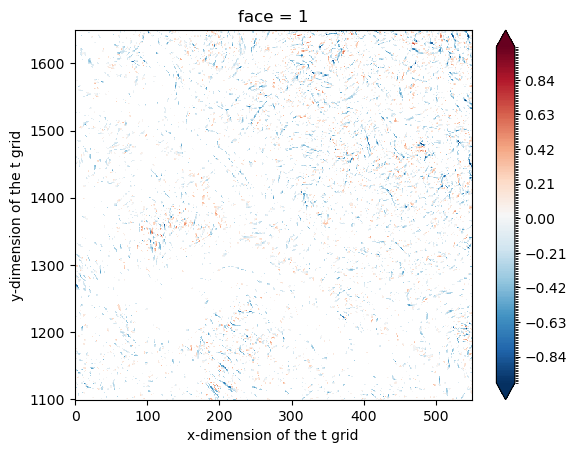

In [49]:
for t in range(0,50):
    plt.clf()
    D_piece2.where(σ_piece2>0.3).isel(time=t).plot(levels=np.arange(-1,1.05,0.01))
    plt.gcf().savefig('div_piece_movie/div_movie_n_%02d.png' % (t))

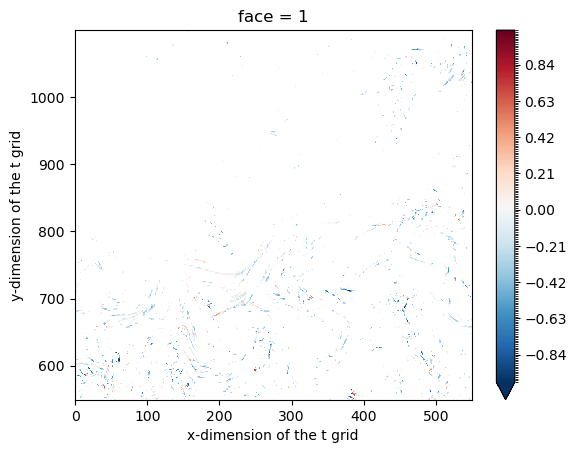

In [101]:
t=0
D_piece2.where((σ_piece2>0.5)&(σ_piece2<1)).isel(time=t).plot(levels=np.arange(-1,1.05,0.01))